# Sistemas Inteligentes 2021/2022

## Mini-projeto 1: Pacman comilão

<img src="pacman.png" alt="Drawing" style="width: 100px;"/>

## Grupo: 50

### Elementos do Grupo

Número: 53841   Nome: Tomás Carrilho     
Número: 54838   Nome: Matilde Carvalho    
Número: 54859   Nome: Rita Rodrigues     

(Nota: Neste relatório pode adicionar as células de texto e código que achar necessárias.)

## Representação dos estados

Um estado é representado por um duplo ((x,y),p) em que (x,y) corresponde às coordenadas da célula em que o Pacman se encontra e p ao número de pontos acumulados.

In [1]:
# se definiu uma classe para representar os estados, inclua aqui o código Python correspondente

In [2]:
# representação de um estado à sua escolha
((x,y),p) = ((1,1),0)

## Formulação do problema

Estado inicial: (x,y,0), em que (x,y) é uma célula dentro dos limites do mundo que não é obstáculo \
Estado final: (x,y,p), em que (x,y) é uma célula dentro dos limites do mundo que não é obstáculo e p >= M é o número de pontos finais, sendo M o mínimo que deve obter

Supomos que todos os labirintos têm uma moldura quadrada.

* Operadores de transição entre estados, dado s=(x,y,p)
    * Norte (N): \
        Condições: y > 1 e (x,y-1) != obstáculo \
        Sucessor: s'=copia(s), s[1]=s[1]-1 e s[2]=s[2]+x 
    * Sul (S): \
        Condições: y < dim-1 e (x,y+1) != obstáculo\
        Sucessor: s'=copia(s), s[1]=s[1]+1 e s[2]=s[2]+x 
    * Este (E): \
        Condições: x < dim-1 e (x+1,y) != obstáculo \
        Sucessor: s'=copia(s), s[0]=s[0]+1 e s[2]=s[2]+x 
    * Oeste (O): \
        Condições: x > 1 e (x-1,y) != obstáculo \
        Sucessor: s'=copia(s), s[0]=s[0]-1 e s[2]=s[2]+x 
    * Em qualquer um dos operadores:
        * x = 0 se a célula sucessora não tem pastilha
        * x = 1 se a célula sucessora tem a pastilha N
        * x = max(0,5-t) em que t é o tempo decorrido até a pastilha ser apanhada se a célula sucessora tem a pastilha D
        * x = t em que t é o tempo decorrido até a pastilha ser apanhada se a célula sucessora tem a pastilha C
        * O custo da operação é 1 se for a primeira vez que o Pacman visita a célula sucessora e n se for a n-ésima

Antes de começarmos a formulação, vamos definir as funções fornecidas no enunciado e construir um conjunto de obstáculos. 

In [3]:
def exec(p,estado,accoes):
    custo = 0
    for a in accoes:
        seg = p.result(estado,a)
        custo = p.path_cost(custo,estado,a,seg)
        estado = seg
    p.display(estado)
    print('Custo:',custo)
    print('Goal?',p.goal_test(estado))
    return (estado,custo)

def line(x, y, dx, dy, length):
    """Uma linha de células de comprimento 'length' começando em (x, y) na direcção (dx, dy)."""
    return {(x + i * dx, y + i * dy) for i in range(length)}

def quadro(x, y, length):
    """Uma moldura quadrada de células de comprimento 'length' começando no topo esquerdo (x, y)."""
    return line(x,y,0,1,length) | line(x+length-1,y,0,1,length) | line(x,y,1,0,length) | line(x,y+length-1,1,0,length)
l = line(2,2,1,0,6)
c = line(2,3,0,1,4)
fronteira = quadro(0,0,10)
obstacles=fronteira | l | c

In [4]:
from searchPlus import *

class PacmanPastilhas(Problem):
    """Obter M pontos (valor passado no parâmetro goal) num mundo onde existem pastilhas.
       Um estado é um tuplo ((x,y),p) em que (x,y) representa a posição do Pacman e p é o nº de pontos acumulados."""
       
    def __init__(self, initial = ((1,1),0), goal=1, pastilhas={}, obstacles=quadro(0,0,10), dim=10):
        self.initial = initial
        self.pacman = initial[0] # (x,y) que representa a posição inicial do Pacman
        self.pontos = initial[1]
        self.goal = goal # o nº mínimo de pontos que o Pacman deve obter
        self.pastilhas = pastilhas # conjunto das pastilhas: dicionário com chaves {N,D,C} e os valores são uma lista de tuplos correspondentes às posições das pastilhas
        self.obstacles = obstacles # conjunto de obstáculos
        self.dim = dim # dimensão do mundo
    
        self.visitadas = [self.pacman]
        self.directions = {"N":(0, -1), "O":(-1, 0),"S":(0, 1), "E":(1,  0)}

        
    def actions(self, state):
        """O Pacman pode mover-se nas quatro direcções ortogonais para as quatro células
           vizinhas desde que não seja impedido pelos limites do mundo nem por obstáculos.
           Uma ação é da forma 'N'. """
        x, y = state[0]
        return [act for act in self.directions.keys() if (x+self.directions[act][0],y+self.directions[act][1]) not in self.obstacles]
        
    def result(self, state, action):
        """Uma ação é da forma 'N' e um estado é um duplo ((x,y),p) em que (x,y) representa a célula onde está o Pacman.
           O resultado será outro duplo ((x,y),p) em que (x,y) representa a célula onde o Pacman irá estar.
           Caso o Pacman coma uma pastilha, os seus pontos aumentam.
           Também é acrescentada a célula sucessora da accao à lista de células visitadas."""
        (x,y) = state[0]
        (dx,dy) = self.directions[action]
        result = [(x+dx,y+dy), state[1]]
        for (k,v) in self.pastilhas.items():
            if result[0] in v:
                self.pastilhas[k].remove(result[0])
                if k == "N":
                    result[1] += 1
                elif k == "D":
                    result[1] += max(0, 5-len(self.visitadas)) #len(self.visitadas) = tempo decorrido até a pastilha ser apanhada
                elif k == "C":
                    result[1] += len(self.visitadas)
                    
        self.visitadas.append(result[0])
        return tuple(result)
    
    def goal_test(self, state):
        """Obter pelo menos os pontos passados no parâmetro goal."""
        return state[1] >= self.goal
    
    def display(self, state):
        """Imprime um estado."""
        output = ""
        for y in range(self.dim):
            for x in range(self.dim):
                if (x,y) == state[0]:
                    output += "@ "
                elif (x,y) in self.obstacles:
                    output += "= "
                else:
                    output += ". "
                for (k,v) in self.pastilhas.items():
                    if (x,y) in v:
                        output = output[:-2] + k + " "
                if (x+1) % self.dim == 0:
                    output += "\n"
        print(output)
        
    def display_trace(self,d,plan):
        path = list()
        st = self.initial
        for a in plan:
            st = self.result(st,a)
            path.append(st[0])
        
        """ print the state please"""
        output=""
        for j in range(d):
            for i in range(d):
                if self.initial[0] ==(i,j):
                    ch = '@'
                elif (i,j) == path[-1]:
                    ch = "*"
                elif (i,j) in self.obstacles:
                    ch = "="
                elif (i,j) in path:
                    ch = '+'
                else:
                    ch = "."
                output += ch + " "
            output += "\n"
        print(output)
        
    def path_cost(self, c, state1, action, state2):
        """O custo de uma accao é 1 se for a 1ª vez que visita a célula e n se for a n-ésima."""
        return c + self.visitadas.count(state2[0])
    
    def __eq__(self, other):
        """Dois estados são iguais se o Pacman estiver na mesma célula e se os pontos forem iguais."""
        return self.pacman == other.pacman and self.pontos == other.pontos
    
    def __lt__(self,other):
        """Um estado é menor que o outro se os pontos forem menores."""
        return self.pontos < other.pontos

## Criação de estados e do problema

(Mostrem que o código está a funcionar, construindo instâncias da classe **PacmanPastilhas**, fazendo display dos estados, verificando o teste do estado final, gerando as ações para alguns estados, executando ações a partir de alguns estados e gerando novos estados e mostrando a evolução dos custos; verificando que os estados não se modificam com as ações (são gerados novos estados) e que a igualdade e a comparação entre estados funciona. Mostrem que a execução de sequências de ações está a funcionar bem.)

Vamos criar um problema da classe PacmanPastilhas.

In [5]:
p1 = PacmanPastilhas(initial=((1,1),0),goal=6,pastilhas={"N":[(2,1), (3,7)], "D":[(4,5)], "C":[(7,3)]},obstacles=fronteira | l | c,dim=10)

Podemos ver o estado inicial do Pacman, no qual o custo ainda é 0:

In [6]:
e1 = p1.initial
print(e1)
custo = 0

((1, 1), 0)


Podemos também ver qual é o número mínimo de pontos que o Pacman tem de atingir.

In [7]:
print(p1.goal)

6


E ainda podemos ver uma representação do mundo.

In [8]:
p1.display(e1)

= = = = = = = = = = 
= @ N . . . . . . = 
= . = = = = = = . = 
= . = . . . . C . = 
= . = . . . . . . = 
= . = . D . . . . = 
= . = . . . . . . = 
= . . N . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



Vamos ver quais são todas as acções possíveis a partir do estado inicial do problema p1.

In [9]:
p1.actions(e1) #resultado esperado: ["E", "S"], porque ["N", "O"] é fronteira

['S', 'E']

Vamos ver qual é o resultado de ir para "S".

In [10]:
e2 = p1.result(e1, "S")
print(e2)

((1, 2), 0)


In [11]:
p1.display(e2)

= = = = = = = = = = 
= . N . . . . . . = 
= @ = = = = = = . = 
= . = . . . . C . = 
= . = . . . . . . = 
= . = . D . . . . = 
= . = . . . . . . = 
= . . N . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



Esta ação tem custo 1, pois é a 1ª vez que o Pacman visita a célula (1,2), verifiquemos esta afirmação:

In [12]:
custo = p1.path_cost(custo, e1, "S", e2 )
print(custo)

1


Verifiquemos que o estado 'e1' não foi modificado.

In [13]:
print(e1)

((1, 1), 0)


Vamos ver as ações possíveis a partir do estado 'e2'.

In [14]:
p1.actions(e2)

['N', 'S']

Caso volte para a casa (1,1), esta accao terá custo 2, ou seja, fica um custo total de 3. Vejamos:

In [15]:
e3 = p1.result(e2, "N")
custo = p1.path_cost(custo, e2, "N", e3)
print(custo)

3


In [16]:
p1.display(e3)

= = = = = = = = = = 
= @ N . . . . . . = 
= . = = = = = = . = 
= . = . . . . C . = 
= . = . . . . . . = 
= . = . D . . . . = 
= . = . . . . . . = 
= . . N . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



Até agora o Pacman ainda não comeu nenhuma pastilha, portanto tem 0 pontos:

In [17]:
e3

((1, 1), 0)

Mas pode ir para "E" e comer uma pastilha N que vale 1 ponto.

In [18]:
e4 = p1.result(e3, "E")

In [19]:
p1.display(e4)

= = = = = = = = = = 
= . @ . . . . . . = 
= . = = = = = = . = 
= . = . . . . C . = 
= . = . . . . . . = 
= . = . D . . . . = 
= . = . . . . . . = 
= . . N . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



In [20]:
e4

((2, 1), 1)

Será que já atingiu o objetivo?

In [21]:
p1.goal_test(e4)

False

Ainda não, tem de chegar a 6 pontos.

Vamos definir outro problema.

In [22]:
p2 = PacmanPastilhas(initial=((4,1),0),goal=8,pastilhas={"N":[(2,1), (1,2)], "D":[(2,4), (4,4)], "C":[(3,2)]},obstacles=quadro(0,0,6),dim=6)

In [23]:
p2.display(p2.initial)

= = = = = = 
= . N . @ = 
= N . C . = 
= . . . . = 
= . D . D = 
= = = = = = 



Vamos executar várias ações até comermos todas as pastilhas.

In [24]:
(final, custo) = exec(p2, p2.initial, ["O","O","S","O","E","E","O","S","S","E","E"])
""" Resultados esperados:
custo = 14
N (2,1): 1
N (1,2): 1
D (2,4): max(0,5-9) = 0
D (4,4): max(0,5-11) = 0
C (3,2): 6
pontos = 8 => goal = True
""" 

= = = = = = 
= . . . . = 
= . . . . = 
= . . . . = 
= . . . @ = 
= = = = = = 

Custo: 14
Goal? True


' Resultados esperados:\ncusto = 14\nN (2,1): 1\nN (1,2): 1\nD (2,4): max(0,5-9) = 0\nD (4,4): max(0,5-11) = 0\nC (3,2): 6\npontos = 8 => goal = True\n'

In [25]:
final

((4, 4), 8)

O estado 'e4' do problema 'p1' é menor que o estado 'final' do problema 'p2', porque tem menor número de pontos. Verifiquemos:

In [26]:
e4 < final

True

Voltemos a definir o problema 'p2' e consideremos de novo o estado inicial.

In [27]:
p2 = PacmanPastilhas(initial=((4,1),0),goal=8,pastilhas={"N":[(2,1), (1,2)], "D":[(2,4), (4,4)], "C":[(3,2)]},obstacles=quadro(0,0,6),dim=6)
s1 = p2.initial
p2.display(s1)

= = = = = = 
= . N . @ = 
= N . C . = 
= . . . . = 
= . D . D = 
= = = = = = 



Vamos andar duas vezes para oeste.

In [28]:
s2 = p2.result(s1,"O")
s3 = p2.result(s2,"O")
p2.display(s3)

= = = = = = 
= . @ . . = 
= N . C . = 
= . . . . = 
= . D . D = 
= = = = = = 



O estado 's3' que pertence ao problema 'p2' é o mesmo que o estado 'e4' que pertence ao problema 'p1'. E é diferente do estado 'e1' do problema 'p1' também. Confirmemos:

In [29]:
print(s3 == e4) # True
print(s3 == e1) # False

True
False


Não é verdade que o estado 's3' do problema 'p2' seja menor que o estado 'e4' do problema 'p1'.

In [30]:
s3 < e4

False

## Teste de procura de solução

(utilização de algoritmos de procura aprendidos nas aulas e comparação dos resultados ao nível de tempo de execução e solução obtida; comente aqui os resultados obtidos e o que observa)

In [31]:
import timeit

In [32]:
p = PacmanPastilhas(initial=((1,1),0),goal=6,pastilhas={"N":[(2,1), (3,7)], "D":[(4,5)], "C":[(7,3)]},obstacles=fronteira | l | c,dim=10)

In [33]:
p.display(p.initial)

= = = = = = = = = = 
= @ N . . . . . . = 
= . = = = = = = . = 
= . = . . . . C . = 
= . = . . . . . . = 
= . = . D . . . . = 
= . = . . . . . . = 
= . . N . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



## Procura em árvore



### Procura em profundidade em árvore



Começámos pela procura em profundidade em árvore, criando uma instância da class PacmanPastilhas com os seguintes atributos


In [34]:
p = PacmanPastilhas(initial=((1,1),0),goal=6,pastilhas={"N":[(2,1), (3,7)], "D":[(4,5)], "C":[(7,3)]},obstacles=fronteira | l | c,dim=10)
p.display(p.initial)

= = = = = = = = = = 
= @ N . . . . . . = 
= . = = = = = = . = 
= . = . . . . C . = 
= . = . . . . . . = 
= . = . D . . . . = 
= . = . . . . . . = 
= . . N . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



Ao aplicarmos o algoritmo de procura em profundidade em árvore a esta instância apercebemo-nos de que não era possível obter uma solução. Fomos portanto averiguar o que se passava e alterámos as funções depth_first_tree_search(problem) e tree_search(problem, frontier) de maneira a que conseguissemos ver quais eram os estados que estavam a ser expandidos para facilitar a formulação de um conclusão.

In [35]:
def depth_first_tree_search1(problem):
    """Search the deepest nodes in the search tree first."""
    return tree_search1(problem, Stack())

def tree_search1(problem, frontier):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    frontier.append(Node(problem.initial))
    while frontier:
        node = frontier.pop()
        print(node)
        if problem.goal_test(node.state):
            return node
        frontier.extend(node.expand(problem))
    return None

In [ ]:
p = PacmanPastilhas(initial=((1,1),0),goal=6,pastilhas={"N":[(2,1), (3,7)], "D":[(4,5)], "C":[(7,3)]},obstacles=fronteira | l | c,dim=10)
print("Resultados da Profundidade em Árvore:")
start = timeit.default_timer()
resultado = depth_first_tree_search1(p)
stop = timeit.default_timer()
print("Time: ", stop - start)
print("Custo:", str(resultado.path_cost))
p.display_trace(5,resultado.solution())

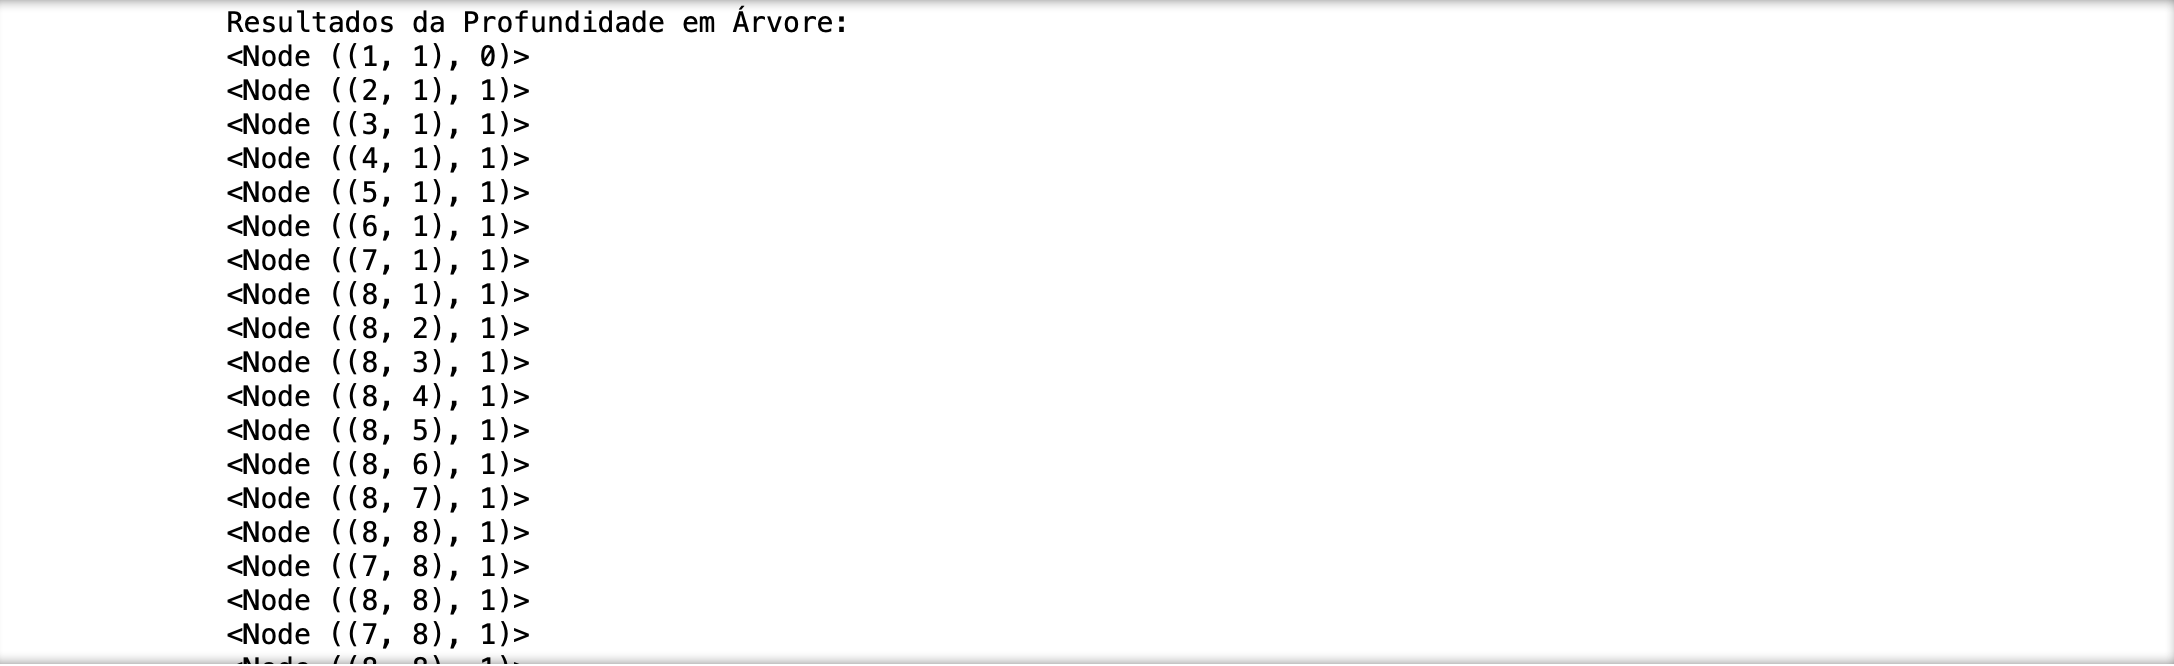

Foi assim possível observar que com este algoritmo entramos num ciclo, pelo que, foi criado uma instância de PacmanPastilhas com um mundo com uma dimensão mais pequena, para facilitar assim a obtenção de um resultado.

In [36]:
p = PacmanPastilhas(initial=((1,1),0),goal=2,pastilhas={"N":[(2,1),(2,3)]},obstacles=quadro(0,0,5),dim=5)
print("Resultados da Profundidade em Árvore:")
start = timeit.default_timer()
resultado = depth_first_tree_search(p)
stop = timeit.default_timer()
print("Time: ", stop - start)
print("Custo:", str(resultado.path_cost))
p.display_trace(5,resultado.solution())

Resultados da Profundidade em Árvore:
Time:  0.00011690000000186274
Custo: 5
= = = = = 
= @ + + = 
= . . + = 
= . * + = 
= = = = = 



Obtemos assim uma solução em que o pacman efetua apenas 5 passos e atinge o seu objetivo. O tempo de execução da procura é consideravelmente baixo, mas isto apenas acontece uma vez que o mundo tem um dimensão mais pequena.

### Procura em largura em árvore

In [37]:
p = PacmanPastilhas(initial=((1,1),0),goal=6,pastilhas={"N":[(2,1), (3,7)], "D":[(4,5)], "C":[(7,3)]},obstacles=fronteira | l | c,dim=10)
print("Resultados da Largura em Árvore:")
start = timeit.default_timer()
resultado = breadth_first_tree_search(p)
stop = timeit.default_timer()
print("Time: ", stop - start)
print("Custo:", str(resultado.path_cost))
print("Caminho:",resultado.solution())
p.display_trace(10,resultado.solution())

Resultados da Largura em Árvore:
Time:  0.19798740000000237
Custo: 10
Caminho: ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'O']
= = = = = = = = = = 
= @ + + + + + + + = 
= . = = = = = = + = 
= . = . . . . * + = 
= . = . . . . . . = 
= . = . . . . . . = 
= . = . . . . . . = 
= . . . . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



A solução obtida tem custo 10, ou seja, o pacman dá 10 passos até atingir o seu objetivo. O tempo de execução é relativamente alto.

### Procura em aprofundamento progressivo em árvore

In [38]:
p = PacmanPastilhas(initial=((1,1),0),goal=6,pastilhas={"N":[(2,1), (3,7)], "D":[(4,5)], "C":[(7,3)]},obstacles=fronteira | l | c,dim=10)
print("Resultados do Aprofundamento Progressivo em Árvore:")
start = timeit.default_timer()
resultado = iterative_deepening_search(p)
stop = timeit.default_timer()
print("Time: ", stop - start)
print("Custo:", str(resultado.path_cost))
print("Caminho:",resultado.solution())
p.display_trace(10,resultado.solution())

Resultados do Aprofundamento Progressivo em Árvore:
Time:  0.19040580000000062
Custo: 1249
Caminho: ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'O']
= = = = = = = = = = 
= @ + + + + + + + = 
= . = = = = = = + = 
= . = . . . . * + = 
= . = . . . . . . = 
= . = . . . . . . = 
= . = . . . . . . = 
= . . . . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



A solução obtida utilizando este algoritmo de procura leva o pacman a dar 10 passos também, no entanto, o custo do resultado é 1249, uma vez que o custo é comulativo à medida que a profundidade vai aumentando. O tempo de execução é muito semelhante ao anterior, mas mais baixo.

### Procura em custo uniforme em árvore

In [39]:
def best_first_tree_search(problem, f):
    f = memoize(f, 'f')
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = PriorityQueue(min, f)
    frontier.append(node)
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node
        for child in node.expand(problem):
                frontier.append(child)
    return None

def uniform_cost_tree_search(problem):
    return best_first_tree_search(problem, lambda node: node.path_cost)

p = PacmanPastilhas(initial=((1,1),0),goal=6,pastilhas={"N":[(2,1), (3,7)], "D":[(4,5)], "C":[(7,3)]},obstacles=fronteira | l | c,dim=10)
print("Resultados do Custo Uniforme em Árvore:")
start = timeit.default_timer()
resultado = uniform_cost_tree_search(p)
stop = timeit.default_timer()
print("Time: ", stop - start)
print("Custo:", str(resultado.path_cost))
print("Caminho:",resultado.solution())
p.display_trace(10,resultado.solution())

Resultados do Custo Uniforme em Árvore:
Time:  0.0025218999999978564
Custo: 10
Caminho: ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'O']
= = = = = = = = = = 
= @ + + + + + + + = 
= . = = = = = = + = 
= . = . . . . * + = 
= . = . . . . . . = 
= . = . . . . . . = 
= . = . . . . . . = 
= . . . . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



A solução obtida, como era espetável, é também de 10 passos, mas, no entanto, o tempo de execução é muito inferior aos anteriores. Para além disso, o método da procura em custo uniforme é completo e otimal, pelo que, a solução encontrada é, sem qualquer tipo de dúvida, a solução ótima.

### Conclusão da procura em árvore

Podemos assim concluir que, no que diz respeito à procura em árvore, a procura em custo uniforme é aquela em que o tempo de execução é menor e, para além disso, temos a certeza de que a solução é ótima.

## Procura em grafo

### Procura em profundidade em grafo

In [40]:
p = PacmanPastilhas(initial=((1,1),0),goal=6,pastilhas={"N":[(2,1), (3,7)], "D":[(4,5)], "C":[(7,3)]},obstacles=fronteira | l | c,dim=10)
print("Resultados da Profundidade em Grafo:")
start = timeit.default_timer()
resultado = depth_first_graph_search(p)
stop = timeit.default_timer()
print("Time: ", stop - start)
print("Custo:", str(resultado.path_cost))
print("Caminho:",resultado.solution())
p.display_trace(10,resultado.solution())

Resultados da Profundidade em Grafo:
Time:  0.002473000000001946
Custo: 10
Caminho: ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'O']
= = = = = = = = = = 
= @ + + + + + + + = 
= . = = = = = = + = 
= . = . . . . * + = 
= . = . . . . . . = 
= . = . . . . . . = 
= . = . . . . . . = 
= . . . . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



A solução obtida tem um custo de 10 passos. O tempo de execução é consideravlemente baixo.

### Procura em largura em grafo

In [41]:
def breadth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first."""
    return graph_search(problem, FIFOQueue())

p = PacmanPastilhas(initial=((1,1),0),goal=6,pastilhas={"N":[(2,1), (3,7)], "D":[(4,5)], "C":[(7,3)]},obstacles=fronteira | l | c,dim=10)
print("Resultados da Largura em Grafo:")
start = timeit.default_timer()
resultado = breadth_first_graph_search(p)
stop = timeit.default_timer()
print("Time: ", stop - start)
print("Custo:", str(resultado.path_cost))
print("Caminho:",resultado.solution())
p.display_trace(10,resultado.solution())

Resultados da Largura em Grafo:
Time:  0.0013268999999951347
Custo: 10
Caminho: ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'O']
= = = = = = = = = = 
= @ + + + + + + + = 
= . = = = = = = + = 
= . = . . . . * + = 
= . = . . . . . . = 
= . = . . . . . . = 
= . = . . . . . . = 
= . . . . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



A solução obtida tem também um custo de 10 passos, mas no entanto, o tempo de execução é muito inferior ao anterior.

### Procura em custo uniforme em grafo

In [42]:
p = PacmanPastilhas(initial=((1,1),0),goal=6,pastilhas={"N":[(2,1), (3,7)], "D":[(4,5)], "C":[(7,3)]},obstacles=fronteira | l | c,dim=10)
print("Pontos iniciais", p.pontos)
print("Resultados do Custo Uniforme em Grafo:")
start = timeit.default_timer()
resultado = uniform_cost_search(p)
stop = timeit.default_timer()
print("Time: ", stop - start)
print("Custo:", str(resultado.path_cost))
print("Caminho:",resultado.solution())
p.display_trace(10,resultado.solution())

Pontos iniciais 0
Resultados do Custo Uniforme em Grafo:
Time:  0.000671400000001654
Custo: 10
Caminho: ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'O']
= = = = = = = = = = 
= @ + + + + + + + = 
= . = = = = = = + = 
= . = . . . . * + = 
= . = . . . . . . = 
= . = . . . . . . = 
= . = . . . . . . = 
= . . . . . . . . = 
= . . . . . . . . = 
= = = = = = = = = = 



Mais uma vez, a solução obtida tem um custo de 10 passos e o tempo de execução é inferior aos anteriores. Para além disso, o método da procura em custo uniforme é completo e otimal, pelo que, a solução encontrada é, sem qualquer tipo de dúvida, a solução ótima.

### Conclusão da procura em grafo

Como era expetável, a procura em custo uniforme é a melhor solução aquando da procura em grafo. 

## Conclusão

Em suma, podemos concluir que, em ambos os métodos de procura (árvore e grafo), o método que mais facilmente encontra a solução ótima é, sem dúvida, o custo uniforme. Mas, ainda assim, a procura em grafo com custo uniforme tem um tempo de execução inferior à procura em árvore. Este facto deve-se a que, na procura em grafo, um estado não pode ser expandido mais do que uma vez, mas pode ser revisitado. De uma forma mais detalhada, um estado só é revisitado caso o caminho que lhe esteja associado, desde o estado inicial, seja infeior ao caminho, desse mesmo estado, que se encontra na fronteira. Temos ainda que, as soluções da procura de custo uniforme em árvore e em grafo são necessariamente as mesmas, facto que pode ser verificado pelos testes realizados mais acima.

Por outro lado, a procura em profundidade é aquela em que o tempo de execução é maior. No entanto, aquando da procura em árvore, nem tão pouco conseguimos encontrar uma solução uma vez que o algoritmo entra num ciclo.